# Heatmap

Used to visualise the decisions that the CNN makes, and the areas of importance in the images fed into it

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
import keras

In [2]:
def load_image(image_path):
    img = image.load_img(image_path, target_size=(128, 128), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [6]:
# Load model
model = keras.models.load_model('./models/128SRNC.h5')

# Load and preprocess input image
image_path = './images/test/cutout_m233_g_ccd_3_9.699287_40.684856.png'
preprocessed_input = load_image(image_path)

# Make predictions
predictions = model.predict(preprocessed_input)
predicted_class_index = np.argmax(predictions[0])
print('Predicted class index:', predicted_class_index)

if predicted_class_index == 0:
    print('Predicted class: Cluster')
else:
    print('Predicted class: Galaxy')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted class index: 0
Predicted class: Cluster


In [7]:
def integrated_gradients(model, baseline, input_image, target_class_idx, num_steps=50):
    """
    Calculates Integrated Gradients for a given input image.

    Args:
        model: The TensorFlow model to use.
        baseline: The baseline input (e.g., a black image).
        input_image: The input image to explain.
        target_class_idx: The index of the target class.
        num_steps: The number of steps for integration.

    Returns:
        The Integrated Gradients attribution.
    """

    # Generate interpolated inputs
    interpolated_images = [
        baseline + (step / num_steps) * (input_image - baseline)
        for step in range(num_steps + 1)
    ]

    # Calculate gradients for each interpolated input
    gradients = []
    for img in interpolated_images:
        with tf.GradientTape() as tape:
            tape.watch(img)
            logits = model(img)  # Get model predictions
            target_logit = logits[:, target_class_idx]  # Extract target class logit

        grad = tape.gradient(target_logit, img)  # Calculate gradient
        gradients.append(grad)

    # Approximate the integral using the trapezoidal rule
    integrated_grads = tf.reduce_mean(gradients, axis=0) * (input_image - baseline)

    return integrated_grads

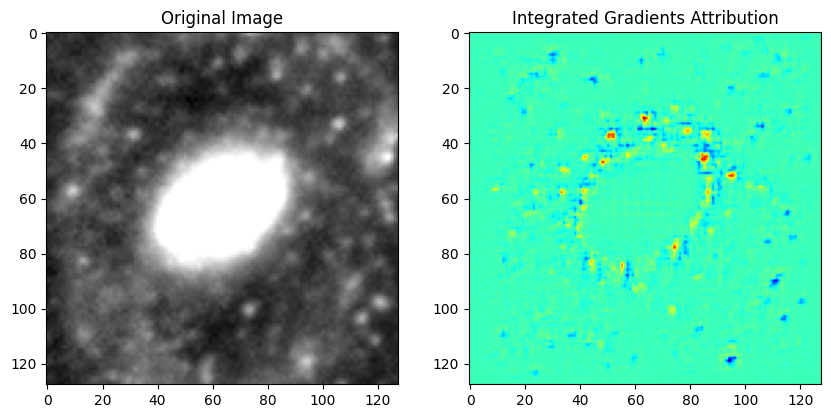

In [ ]:

# Create a baseline input
baseline = tf.zeros_like(preprocessed_input)

# Calculate Integrated Gradients
integrated_grads = integrated_gradients(model, baseline, preprocessed_input, predicted_class_index)

# Visualise
attribution_map = integrated_grads.numpy().squeeze()

# Plot the original image and the attribution map
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(preprocessed_input.squeeze(), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(attribution_map, cmap='jet')
plt.title('Integrated Gradients Attribution')

plt.show()